## Нейронный движок игры

- предсказываем P(s_next|s_now, action, zoom, sp, N_steps)
- s_next = s_now + dt, где dt = N timestamps, минимальное dt = 1 step в любых экспериментах (в v2 dt мог быть = 0)
- zoom везде = 1
- model=Res18Unet(3)
- Состояние S - RGB кадр shape=(96,96,3)
- loss = l1 + l2, где:
        l1 = MAE(model(s_now,N),s_next)+PL_loss(model(s_now,N),s_next)
        l2 = MAE(model(model(s_now,m),N-m),s_next)+PL_loss(model(model(s_now,m),N-m),s_next)
- **loss = 3*MAE+PL/1000**
- **больше эпох**

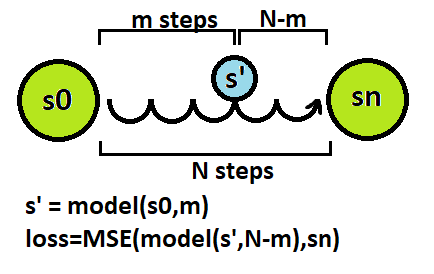

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

    
def plot_samples_on_epoch(samples, nrow=8, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
        
def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    plt.grid()
    plt.show()
#----------------------------------------------------------------------------------------------------
        
# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0


## Data

In [2]:
def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]

#df_train.to_csv('df_train.csv', index=False)
#df_val.to_csv('df_val.csv', index=False)
#d_train.to_csv('d_train.csv', index=False)
#d_val.to_csv('d_val.csv', index=False)

df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
d_train = pd.read_csv('d_train.csv') #.head(128)
d_val = pd.read_csv('d_val.csv') #.head(128)

In [3]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p


class Surviv_Dataset(Dataset):
    def __init__(self,
                 dataset,
                 df,
                 augs=None):
        super().__init__()
        self.dataset = dataset
        self.df = df
        self.augs = augs
        self.dir_aug = np.array([[0,1,2,3,4,5,6,7,8], # real image
                                 [0,3,4,5,6,7,8,1,2], # rotate 90 o'clock
                                 [0,5,6,7,8,1,2,3,4], # rotate 180    
                                 [0,7,8,1,2,3,4,5,6], # rotate 270
                                 [0,1,8,7,6,5,4,3,2], # real image + gor flip
                                 [0,7,6,5,4,3,2,1,8], # rotate 90 o'clock + gor flip
                                 [0,5,4,3,2,1,8,7,6], # rotate 180 + gor flip
                                 [0,3,2,1,8,7,6,5,4]]) # rotate 270 + gor flip
  
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        i = self.dataset[idx][1]
        n = min(14,np.random.randint(2,self.dataset[idx][2]+2))
        m = np.random.randint(1,n)
        s0 = load_image(self.df[i][0], self.df[i][2])
        s1 = load_image(self.df[i+n][0], self.df[i+n][2])
        _dir = self.df[i][24]
        sp = torch.tensor(self.df[i][4])/100
        zoom = torch.tensor(self.df[i][17])/15
        
        aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
        _dir = self.dir_aug[aug,_dir]
        s0 = apply_aug(s0, aug)
        s1 = apply_aug(s1, aug)
        
        if self.augs is not None:
            s0 = self.augs(image=s0)['image']
            s1 = self.augs(image=s1)['image']
        
        _dir = F.one_hot(torch.tensor(_dir-1), num_classes=8).float()
        _dir = torch.cat([_dir,sp.unsqueeze(0),zoom.unsqueeze(0)])
        
        return s0, s1, _dir, torch.tensor(n).unsqueeze(0), torch.tensor(m).unsqueeze(0)

## Model

In [4]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1) # (bath,10+1) --> (batch,512)
        
    def forward(self, inp):

        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4+cond)
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out

In [5]:
trainloss_ts = []
trainiou_ts = []
valloss_ts = []
valiou_ts = []

def train_model(model, train_iterator, val_iterator, loss_func, optimizer, sheduler, params):
    
    best_model_wts = model.state_dict()
    best_loss = 1000
    VGG = VGG_for_pl().to(params['DEVICE']).eval()
    MSE = nn.MSELoss()
    
    for i in range(params['EPOCHS']):
        #===========TRAIN=============================
        time.sleep(0.2)
        model.train(True)
        train_loss = 0.0
        for x in enumerate(tqdm(train_iterator)):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2]
            n = x[1][3]/14
            m = x[1][4]/14
            _dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
            _dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
            _dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])
            
            optimizer.zero_grad()
            prediction1 = model((img,_dir1))
            prediction2 = model((model((img,_dir2)),_dir3))
            loss = loss_func(prediction1, target)+loss_func(prediction2, target)
            #---PL LOSS------------
            target_f = VGG(target)
            pred1_f = VGG(prediction1)
            pred2_f = VGG(prediction2)
            pl_loss = 0
            for ii in range(len(target_f)):
                pl_loss = pl_loss+MSE(pred1_f[ii], target_f[ii].detach())+\
                                  MSE(pred2_f[ii], target_f[ii].detach())
            #print(loss.item(),pl_loss.item())
            loss = 3*loss + pl_loss/100
            #----------------------
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            
        current_lr = optimizer.param_groups[0]['lr']
        sheduler.step()
        train_loss = round(train_loss / len(train_iterator),4)
        trainloss_ts.append(train_loss)

        #===========VAL==============================
        time.sleep(0.2)
        model.train(False)
        val_loss = 0.0
        for x in enumerate(val_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            _dir = x[1][2]
            n = x[1][3]/14
            m = x[1][4]/14
            _dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
            _dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
            _dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])
            
            with torch.no_grad():
                prediction1 = model((img,_dir1))
                prediction2 = model((model((img,_dir2)),_dir3))
            loss = loss_func(prediction1, target)+loss_func(prediction2, target)  
            val_loss += loss.item()
        val_loss = round(val_loss / len(val_iterator),4)
        valloss_ts.append(val_loss)

        if val_loss<best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, 'resunet_mae_pl.pth')       

        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'lr:',current_lr,'|',
              'train_loss:',trainloss_ts[-1],'|',
              'val_loss:',valloss_ts[-1])

In [6]:
# for perceptual loss
class VGG_for_pl(nn.Module):
    
    def __init__(self, chosen_features=[0,5,10,19,28]):
        super().__init__()
        self.model = models.vgg19(pretrained=True).features
        self.chosen_features = chosen_features
        self.model_parts = []
        prev_layer = self.chosen_features[0]
        for i in range(len(self.chosen_features)):
            curr_layer = self.chosen_features[i]+1
            #print(prev_layer, curr_layer) #[0 1]; [1 6]; [6 11]; [11 20]; [20 29]
            self.model_parts.append(nn.Sequential(*(list(self.model.children())[prev_layer:curr_layer])))
            prev_layer = curr_layer
            
    def forward(self, x):
        features = []
        for part in self.model_parts:
            x = part(x)
            features.append(x)
        return features
#------------------------------------------

params = {'EPOCHS': 10,
          'DEVICE': 'cuda:0',
          'BATCH': 32}
  
train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                       ToTensorV2(transpose_mask=False),
                      ])

train_data = Surviv_Dataset(d_train.values, df_train.values, train_aug)
train_dataloader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)

test_data = Surviv_Dataset(d_val.values, df_val.values, train_aug)
test_dataloader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)

model = ResNetUNet(n_class=3).to(params['DEVICE'])
loss_fn = nn.L1Loss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)
#save_path = './trained_models/unet_resnet.pth'

train_model(model, train_dataloader, test_dataloader,
            loss_fn, opt, scheduler, params)

100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


1/10 lr: 0.001 | train_loss: 3.7667 | val_loss: 0.9255


100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


2/10 lr: 0.001 | train_loss: 2.6162 | val_loss: 0.5546


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


3/10 lr: 0.001 | train_loss: 2.3353 | val_loss: 0.5131


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


4/10 lr: 0.0001 | train_loss: 2.1592 | val_loss: 0.5223


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


5/10 lr: 0.0001 | train_loss: 2.1719 | val_loss: 0.5286


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


6/10 lr: 0.0001 | train_loss: 2.1771 | val_loss: 0.5316


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


7/10 lr: 1e-05 | train_loss: 2.139 | val_loss: 0.5277


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


8/10 lr: 1e-05 | train_loss: 2.1406 | val_loss: 0.5288


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


9/10 lr: 1e-05 | train_loss: 2.0766 | val_loss: 0.5285


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


10/10 lr: 1.0000000000000002e-06 | train_loss: 2.0874 | val_loss: 0.5283


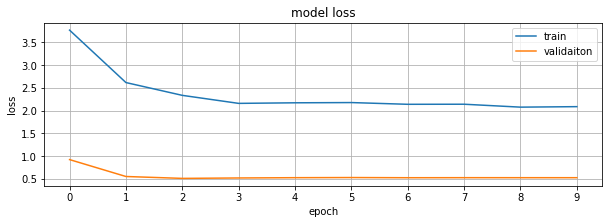

In [7]:
plt.figure(figsize=(10,3));
plt.plot(np.array(trainloss_ts))
plt.plot(np.array(valloss_ts))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10))
plt.legend(['train', 'validaiton'])
plt.grid()
plt.show()

## Validation trained model

tensor([[8],
        [5],
        [2],
        [4]])
MSE: 0.0138


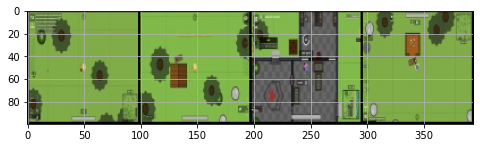

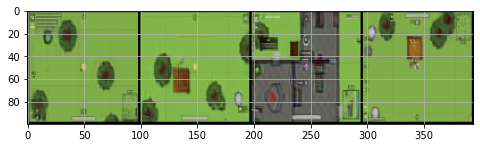

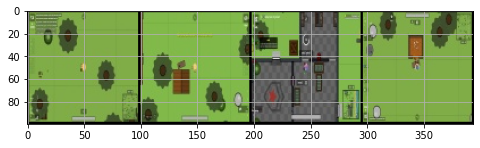

In [8]:
img, target, _dir, n, m = iter(test_dataloader).next()
print(n[:4])

img = img.to(params['DEVICE'])
target = target.to(params['DEVICE'])
n = n/14
m = n/14
_dir1 = torch.cat([_dir,n], dim=1).to(params['DEVICE'])
_dir2 = torch.cat([_dir,m], dim=1).to(params['DEVICE'])
_dir3 = torch.cat([_dir,n-m], dim=1).to(params['DEVICE'])


model.train(False)
with torch.no_grad():
    prediction = model((img,_dir1))
loss = round(F.mse_loss(prediction, target).item(),4)
print('MSE:', loss)
#print(img.size(),target.size(), prediction.size())

img = img.detach().cpu()[:4]
target = target.detach().cpu()[:4]
prediction = prediction.detach().cpu()[:4]

plot_samples_on_epoch((img+1)/2)
plot_samples_on_epoch((prediction+1)/2)
plot_samples_on_epoch((target+1)/2)

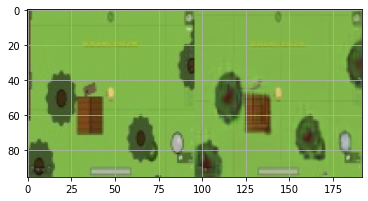

In [9]:
k = 1
s0 = img[k].permute(1,2,0)
s1 = target[k].permute(1,2,0)
s2 = prediction[k].permute(1,2,0)

s_start = torch.cat([s0,s0], axis=1)
s_end = torch.cat([s1,s2], axis=1)

for i in range(10):

    see_plot((s_start+1)/2)
    time.sleep(0.2)
    display.clear_output(wait=True)
    
    see_plot((s_end+1)/2)
    time.sleep(1)
    display.clear_output(wait=True)

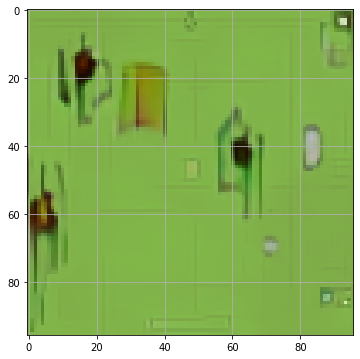

In [10]:
k = 1
s0 = img[k] # torch.Size([3, 96, 96])
inv0 = _dir[k][-2:].detach().cpu() # torch.Size([2])

see_plot(s0.permute(1,2,0)/2+0.5)
time.sleep(0.1)

model.train(False)
s0 = s0.unsqueeze(0)
s = s0.to(params['DEVICE'])

for i in range(20):
     
    d = 5 #np.random.randint(1,9) #input()
    n = 1 #input()
    d = int(d)
    n = int(n)/14
    
    dd = F.one_hot(torch.tensor(d-1), num_classes=8).float()
    dd = torch.cat([dd,inv0,torch.tensor(n).unsqueeze(0)]).unsqueeze(0).to(params['DEVICE'])
    with torch.no_grad():
        s = model((s,dd))
    display.clear_output(wait=True)
    see_plot(s[0].permute(1,2,0).detach().cpu()/2+0.5)
    time.sleep(0.5)